A notebook for visualizing the various space filling curves implemented for the thesis. Also compares the two methods for generalizing the sfc's to arbitrary images, and the hamiltonian path generation for those curves.

We start by importing the `space_filling_curves.py` module

In [13]:
import sys
sys.path.append('..')

from src.curves.space_filling_curves import *
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np

Visualise all the curves of order 1 to 3 on the unit square

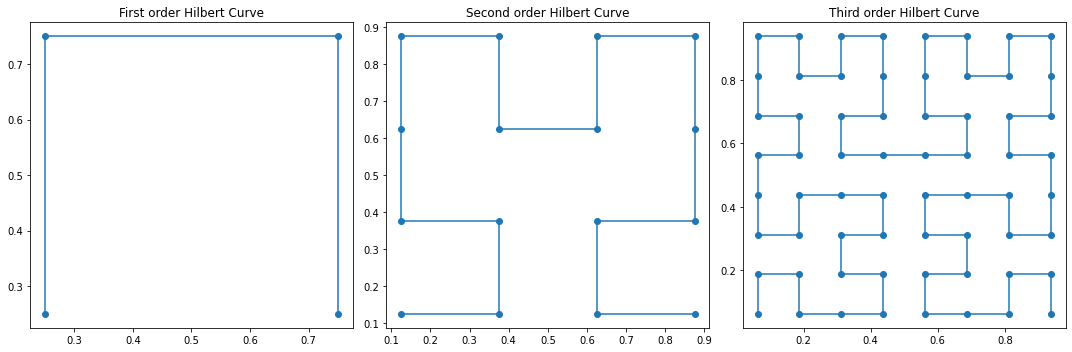

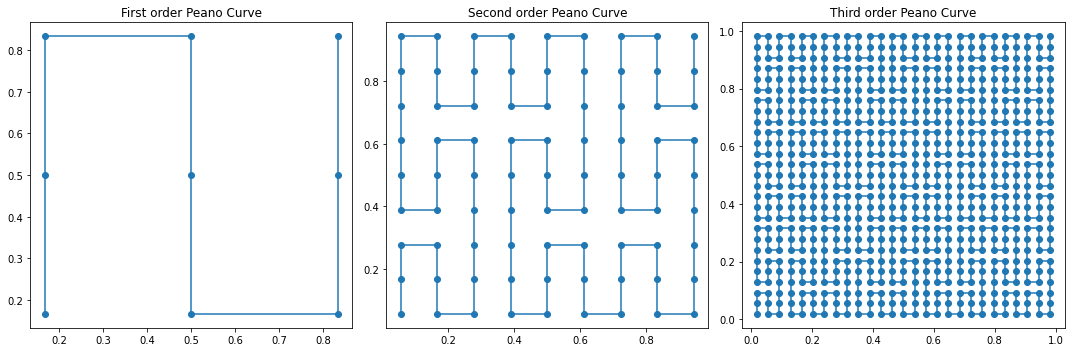

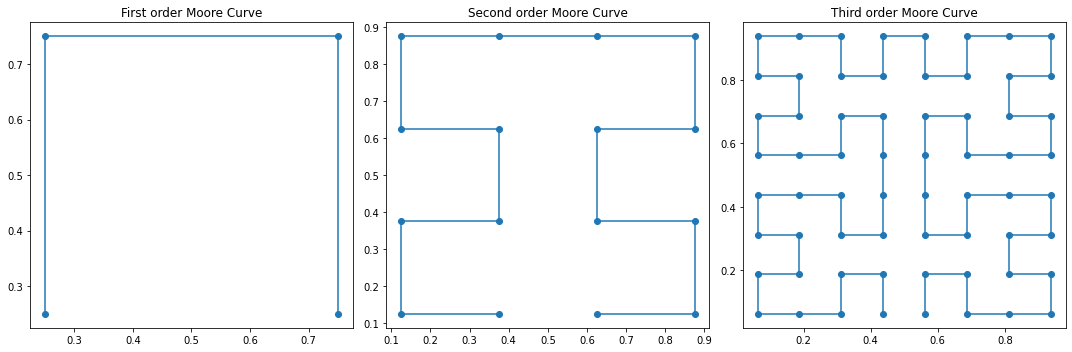

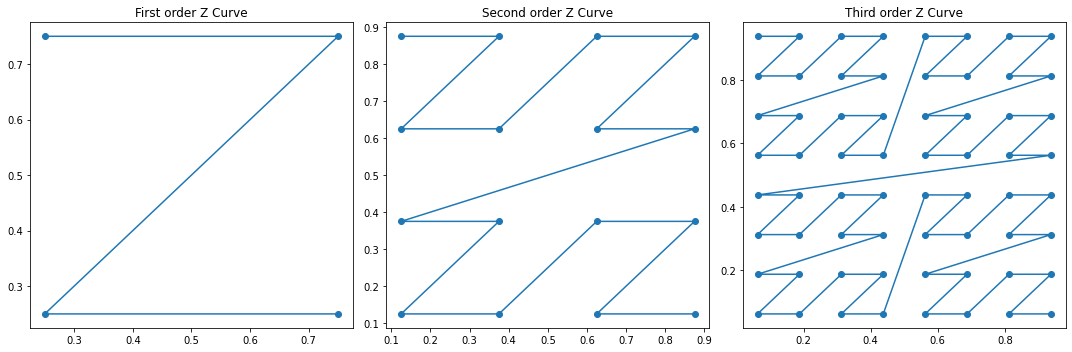

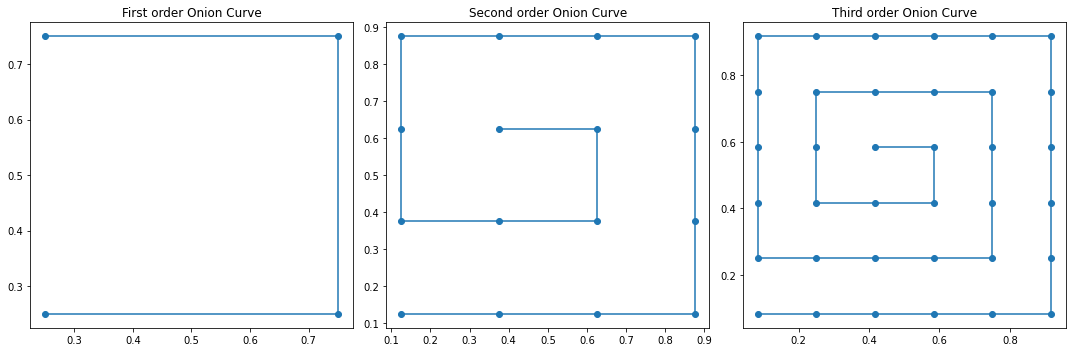

In [2]:
def visualise_sfc(sfc, orders):
    _, ax = plt.subplots(1, len(orders), figsize=(15, 5))
    for i, o in enumerate(orders):
        curve = sfc(o, 1)  # Assume this returns a list of (x, y) tuples
        name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
        x, y = zip(*curve)  # unzip into x and y coordinates
        ax[i].plot(x, y, marker='o')
        prefix = "First" if o == 1 else "Second" if o == 2 else "Third"
        ax[i].set_title(f"{prefix} order {name}")

    plt.tight_layout()
    plt.show()

order = [1, 2, 3]
visualise_sfc(hilbert_curve, order)
visualise_sfc(peano_curve, order)
visualise_sfc(moore_curve, order)
visualise_sfc(z_curve, order)
visualise_sfc(onion_curve, order)

One problem with these curves is that they are only defined on images with a power of 2 size (power of 3 in the case of the peano curve). One solution is to generate a bigger sfc and downsample it to the size of the image. This is done by generating a sfc of size $2^n$ and then downsampling it to the size of the image. Below is an example of generating sfc on a 7x7 image, which is not a grid of $2^n$.

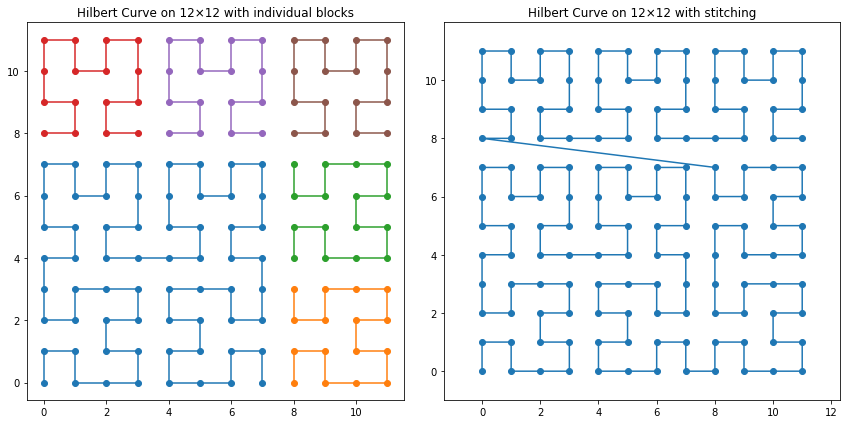

In [3]:
height = 12
width = 12

curve, blocked_curve = block_stitch_sfc(hilbert_curve, width, height)

# Plot the curve
x_vals, y_vals = zip(*curve)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[1].plot(x_vals, y_vals, marker='o')
axs[1].axis('equal')
axs[1].set_title(f"Hilbert Curve on {width}×{height} with stitching")

# Plot the blocked curve
for block in blocked_curve:
    x_vals, y_vals = zip(*block)
    axs[0].plot(x_vals, y_vals, marker='o')
axs[0].set_aspect('equal')
axs[0].set_title(f"Hilbert Curve on {width}×{height} with individual blocks")

plt.tight_layout()
plt.show()


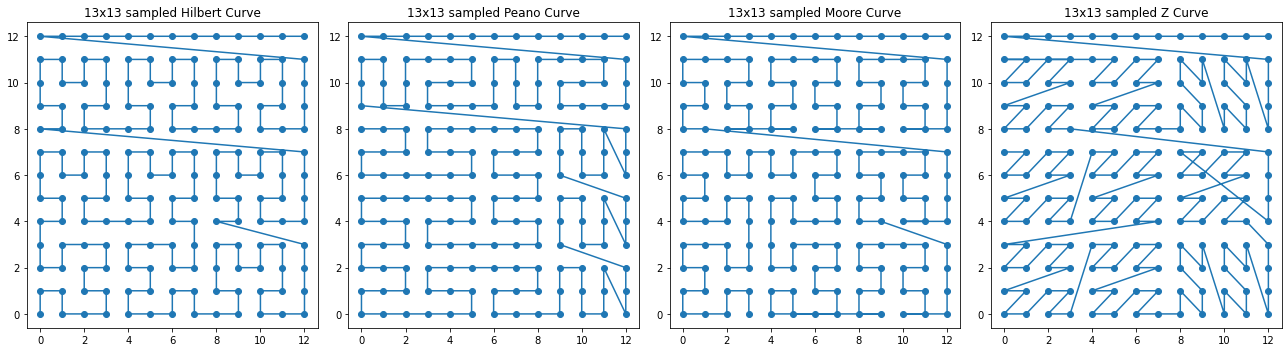

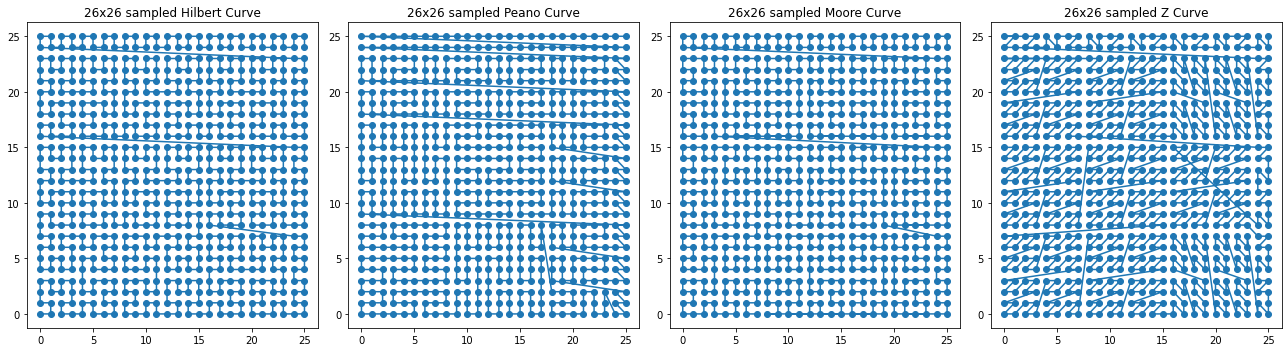

In [4]:
def visualise_sampled_sfc_combined(sfc_list, height, width):
    _, ax = plt.subplots(1, len(sfc_list), figsize=(18, 5))
    for i, sfc in enumerate(sfc_list):
        curve, _ = block_stitch_sfc(sfc, width, height)  # Assume this returns a list of (x, y) tuples
        name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
        x, y = zip(*curve)  # unzip into x and y coordinates
        ax[i].plot(x, y, marker='o')
        ax[i].set_title(f"{height}x{width} sampled {name}")

    plt.tight_layout()
    plt.show()

height = 13
width = 13
sfc_list = [hilbert_curve, peano_curve, moore_curve, z_curve]
visualise_sampled_sfc_combined(sfc_list, height, width)
visualise_sampled_sfc_combined(sfc_list, height * 2, height * 2)

Another way to do this is to generate a sfc on a padded square grid of sufficient size and then pruning points that fall outside the desired domain. First we visualize the algorithm of embedding and pruning, and then we visualize the algorithm on some grids with various SFC's

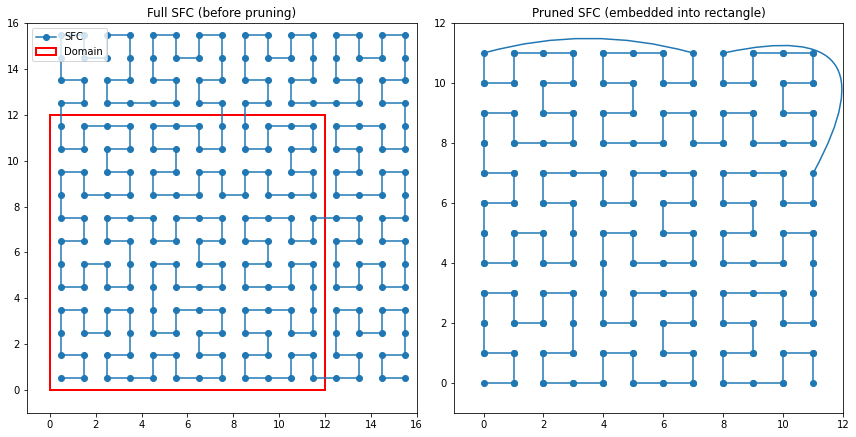

In [44]:
def draw_curve(ax, p0, p1, color='C0', linewidth=1.5, mod=0.02):
    """
    Draw a curved link between two grid points p0 and p1.
    """
    mid_x = (p0[0] + p1[0]) / 2
    mid_y = (p0[1] + p1[1]) / 2
    dist = np.sqrt((p1[0] - p0[0]) ** 2 + (p1[1] - p0[1]) ** 2)

    # Control point to curve around the grid center (adjust curvature)
    dx = p1[0] - p0[0]
    dy = p1[1] - p0[1]
    control = (mid_x - dy * 0.3, mid_y + dx * 0.3)

    if dist == 1:
        # Straight line for adjacent points
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=color, linewidth=linewidth, marker='o')
        return True
    else:
        # Draw Bezier curve manually
        patch = FancyArrowPatch(
            p0, p1,
            connectionstyle=f"arc3,rad={-dist * mod}",
            arrowstyle='-',
            color=color,
            linewidth=linewidth
        )
        ax.add_patch(patch)
        return False

width, height = 12, 12
order = 0
sfc = hilbert_curve
while grid_size(order, sfc) < max(width, height):
    order += 1

# Generate on the padded square, then prune out‑of‑domain points
P = grid_size(order, sfc)
raw = hilbert_curve(order, P)  # Assume this returns a list of (x, y) tuples

raw_x, raw_y = zip(*raw)  # unzip into x and y coordinates

# prune the curve
pruned = []
for x, y in raw:
    i, j = int(np.floor(x)), int(np.floor(y))
    if 0 <= i < width and 0 <= j < height:
        pruned.append((i, j))

if pruned:
    pruned_x, pruned_y = zip(*pruned)
else:
    pruned_x, pruned_y = [], []


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Full curve
axs[0].plot(raw_x, raw_y, marker='o')
axs[0].set_title("Full SFC (before pruning)")
axs[0].add_patch(plt.Rectangle((0, 0), width, height, fill=False, color='red', lw=2))
axs[0].set_xlim(-1, P)
axs[0].set_ylim(-1, P)
axs[0].set_aspect('equal')
axs[0].legend(['SFC', 'Domain'], loc='upper left')

# Pruned curve
axs[1].scatter(pruned_x, pruned_y, s=10, color='C0')
mod = 0.02
for i in range(len(pruned) - 1):
    p0 = pruned[i]
    p1 = pruned[i + 1]
    if not draw_curve(axs[1], p0, p1, color='C0', mod=mod):
        mod += 0.2
axs[1].set_title("Pruned SFC (embedded into rectangle)")
axs[1].set_xlim(-1, width)
axs[1].set_ylim(-1, height)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

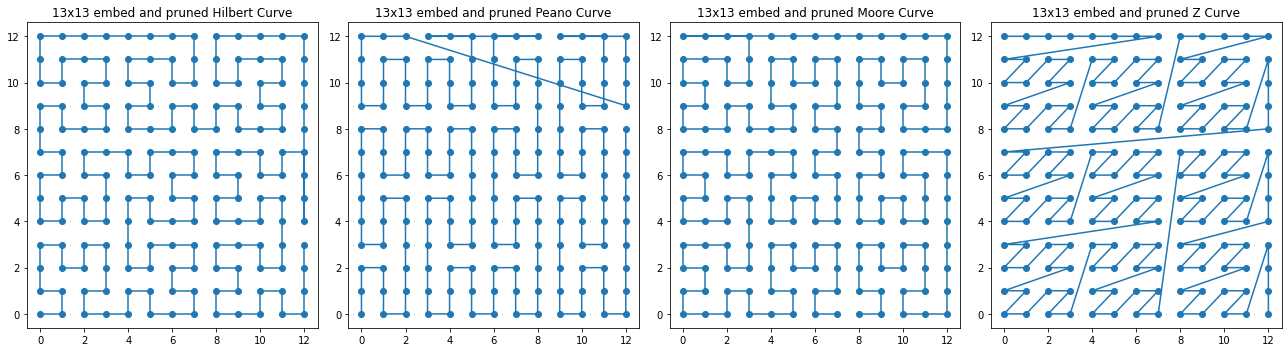

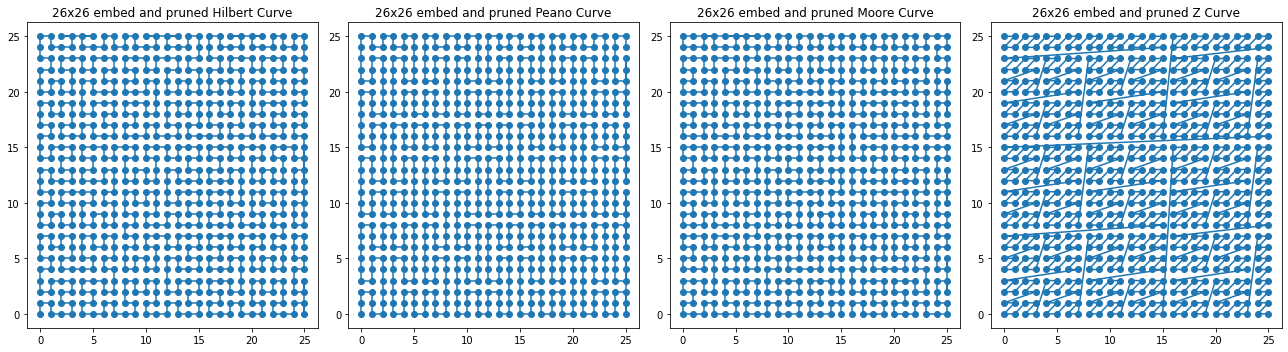

In [7]:
def visualise_embed_and_pruned_sfc_combined(sfc_list, height, width):
    _, ax = plt.subplots(1, len(sfc_list), figsize=(18, 5))
    for i, sfc in enumerate(sfc_list):
        curve = embed_and_prune_sfc(sfc, width, height)  # Assume this returns a list of (x, y) tuples
        name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
        x, y = zip(*curve)  # unzip into x and y coordinates
        ax[i].plot(x, y, marker='o')
        ax[i].set_title(f"{height}x{width} embed and pruned {name}")

    plt.tight_layout()
    plt.show()

sfc_list = [hilbert_curve, peano_curve, moore_curve, z_curve]
visualise_embed_and_pruned_sfc_combined(sfc_list, height, width)
visualise_embed_and_pruned_sfc_combined(sfc_list, height * 2, width * 2)

One problem with both of these approaches is that they do not guarantee a Hamiltonian path. The Hamiltonian path is a path that visits every point in the grid exactly once. This is important for the sfc to be a valid space filling curve. Although this property isn't necessary for the use-end of this project, it is still a nice property to have. This is due to jumps being made in both methods, which is detrimental to locality. Below we use a function from the `space_filling_curves.py` module to to post-process the sampled/pruned sfc back to a Hamiltonian path. Note that not all the pruned/sampled sfc's can be reconstructed back into a hamiltonian path, in that case, we'll leave it as is.

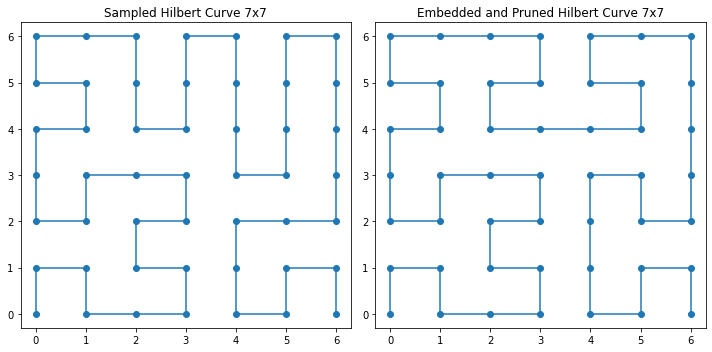

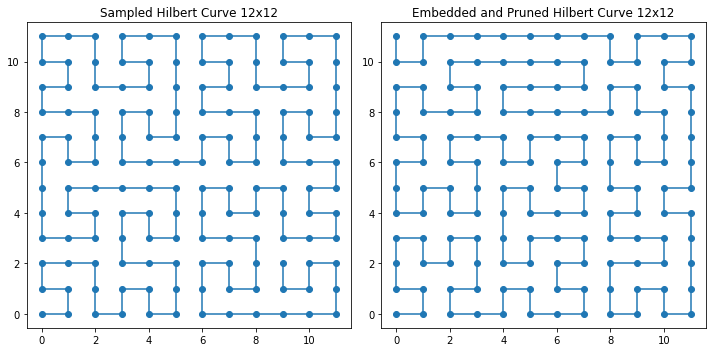

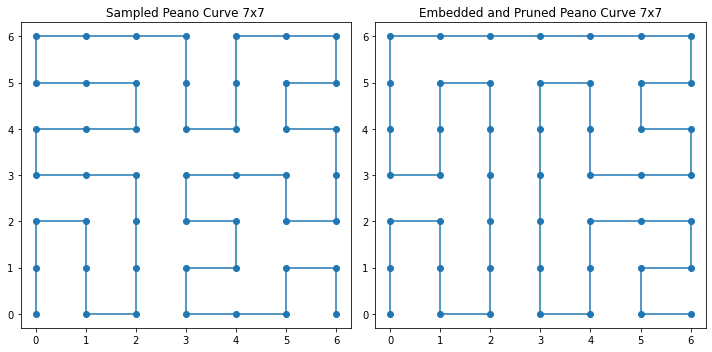

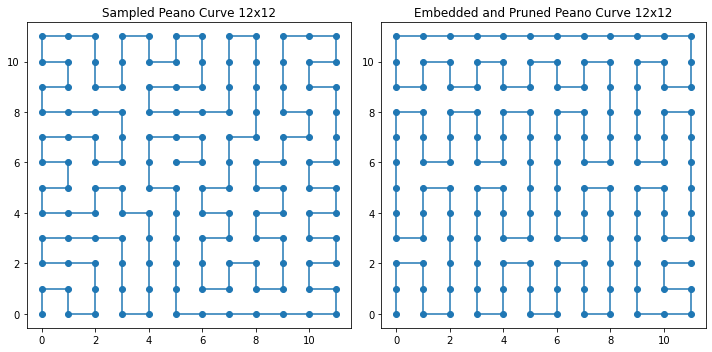

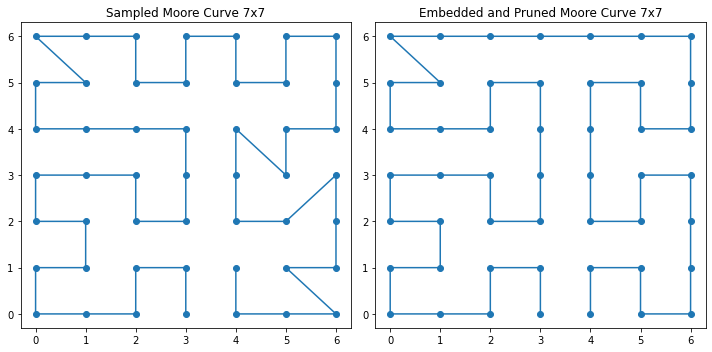

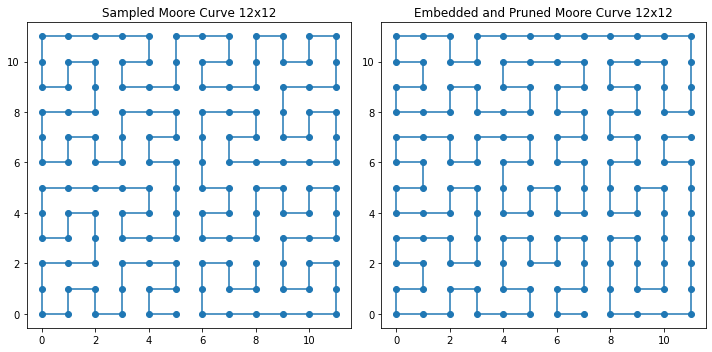

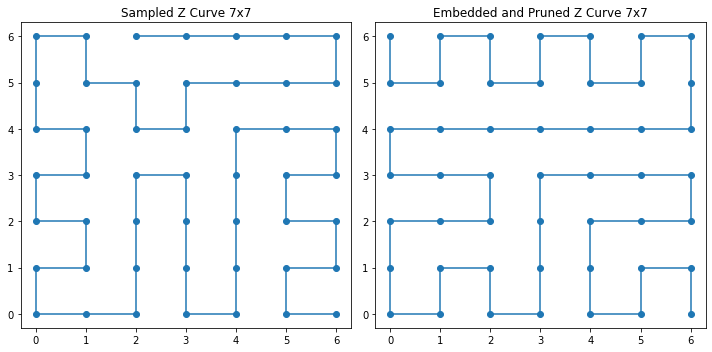

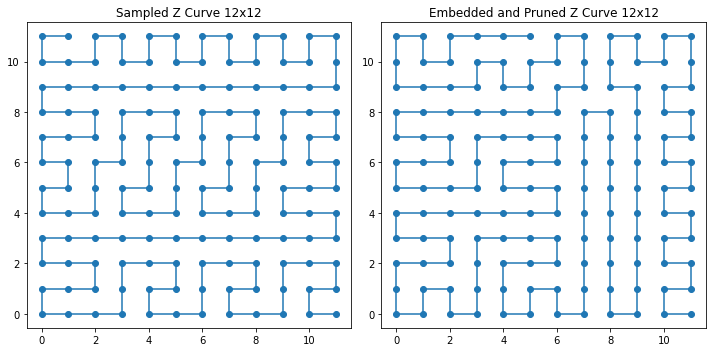

In [5]:
def visualise_hamiltonian_reconstruction(sfc, height, width):
    """
    Visualise the Hamiltonian reconstruction of a space-filling curve.
    Generates a plot of the reconstructed curve for both the sampled and
    the embedded and pruned versions next to each other.
    """
    _, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Sampled SFC
    sampled_curve = refine_curve_to_hamiltonian(sample_sfc(sfc, width, height), width, height)
    name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
    x_sampled, y_sampled = zip(*sampled_curve)  # unzip into x and y coordinates
    ax[0].plot(x_sampled, y_sampled, marker='o')
    ax[0].set_title(f"Sampled {name} {height}x{width}")

    # Embedded and Pruned SFC
    embedded_curve = refine_curve_to_hamiltonian(embed_and_prune_sfc(sfc, width, height), width, height)
    x_embedded, y_embedded = zip(*embedded_curve)  # unzip into x and y coordinates
    ax[1].plot(x_embedded, y_embedded, marker='o')
    ax[1].set_title(f"Embedded and Pruned {name} {height}x{width}")

    plt.tight_layout()
    plt.show()

sfc_list = [hilbert_curve, peano_curve, moore_curve, z_curve]
for sfc in sfc_list:
    visualise_hamiltonian_reconstruction(sfc, height, width)
    visualise_hamiltonian_reconstruction(sfc, 12, 12)

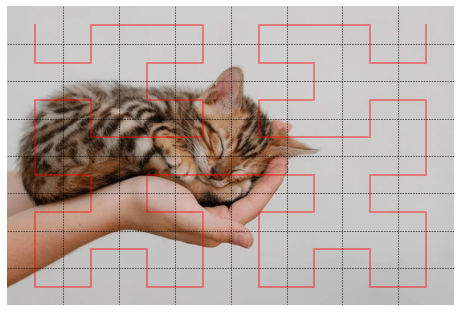

/tmp/ipykernel_18906/872814208.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.array(img)


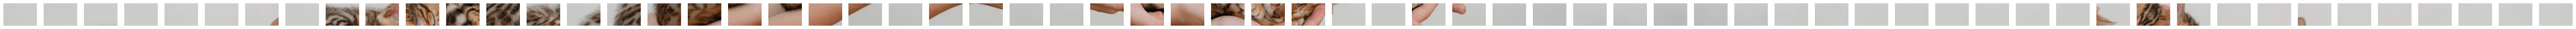

In [115]:
from PIL import Image

import matplotlib.pyplot as plt

def flatten_image_by_custom_hilbert(image_path, order):
    # Load image and ensure RGB
    img = Image.open(image_path).convert("RGB")
    width, height = img.size
    data = np.array(img)

    n = 2 ** order  # Grid size (e.g., 8 for order=3)

    # Generate normalized Hilbert coordinates
    coords = hilbert_curve(order)  # Returns (x, y) in [0, 1)

    # Convert to grid indices, preserving spatial coverage
    grid_coords = [(int(x * n), int(y * n)) for x, y in coords]
    grid_coords = [(min(x, n - 1), min(y, n - 1)) for x, y in grid_coords]

    # Compute patch size in pixels
    cell_w, cell_h = width // n, height // n

    patches = []
    for x, y in grid_coords:
        x1, x2 = x * cell_w, (x + 1) * cell_w
        y1, y2 = y * cell_h, (y + 1) * cell_h
        patch = data[y1:y2, x1:x2]
        patches.append(patch)

    return patches

def draw_sfc_on_image(image_path, sfc, order):
    """
    Draw a space-filling curve on top of a given image and overlay a grid.

    Parameters:
        image_path (str): Path to the input JPG image.
        sfc (Callable): Space-filling curve function.
        order (int): Order of the space-filling curve.
    """
    # Load the image
    img = Image.open(image_path)
    width, height = img.size

    # Generate the space-filling curve
    curve = sfc(order, max(width, height))
    x, y = zip(*curve)

    # Scale the curve to fit the image dimensions
    x = [xi * width / max(width, height) for xi in x]
    y = [yi * height / max(width, height) for yi in y]

    # Plot the image and the curve
    plt.figure(figsize=(8, 8))
    plt.imshow(img)

    # Overlay the space-filling curve
    plt.plot(x, y, color='red', linewidth=2, alpha=0.4)

    # Overlay a 4x4 grid
    for i in range(1, 8):
        plt.axhline(y=i * height / 8, color='black', linestyle='--', linewidth=0.5)
        plt.axvline(x=i * width / 8, color='black', linestyle='--', linewidth=0.5)

    plt.axis('off')
    plt.show()

# Example usage
image_path = "cat.jpg"  # Replace with the path to your image
draw_sfc_on_image(image_path, hilbert_curve, order=3)
patches = flatten_image_by_custom_hilbert(image_path, order=3)
plt.figure(figsize=(96, 32))
for i in range(64):
    plt.subplot(1, 64, i+1)
    plt.imshow(patches[i])
    plt.axis("off")
plt.show()

Now we are going to conduct some statistical tests on both the sampled and pruned sfc's in order to see which are better at preserving locality and such. 

In [44]:
from concurrent.futures import ProcessPoolExecutor
import random

def compute_clustering_number(curve, width, height, query_size, sample_windows):
    # Build inverse mapping: cell -> index in curve
    position = {cell: idx for idx, cell in enumerate(curve)}
    qh, qw = query_size

    # Generate list of all possible window top-left corners
    all_positions = [(y, x)
                     for y in range(height - qh + 1)
                     for x in range(width - qw + 1)]
    if sample_windows:
        all_positions = random.sample(all_positions, min(sample_windows, len(all_positions)))

    cluster_counts = []
    for y0, x0 in all_positions:
        # Collect indices for this window
        indices = []
        for dy in range(qh):
            for dx in range(qw):
                idx = position[(x0 + dx, y0 + dy)]
                indices.append(idx)
        indices.sort()
        # Count clusters: starts with 1, increment when gap > 1
        clusters = 1 + sum((indices[i] + 1 != indices[i+1]) for i in range(len(indices)-1))
        cluster_counts.append(clusters)

    return float(np.mean(cluster_counts))

def compute_curve_stats(curve, width, height):
    """
    Normalize all segment‐length stats to the unit square [0,1]×[0,1],
    then compute summary statistics.
    """
    xs, ys = zip(*curve)
    xs = np.array(xs, dtype=float)
    ys = np.array(ys, dtype=float)

    # scale so that the largest dimension maps to 1.0
    scale = max(width - 1, height - 1) or 1
    xs /= scale
    ys /= scale

    dx = np.diff(xs)
    dy = np.diff(ys)
    lengths = np.hypot(dx, dy)
    return {
        'total_length':   lengths.sum(),
        'avg_segment_length': lengths.mean(),
        'max_segment_length': lengths.max(),
        'std_segment_length': lengths.std(),
    }

def compare_sfc_versions(sfc, height, width):
    # build both curves
    stitched, _ = block_stitch_sfc(sfc, width, height)
    embedded = embed_and_prune_sfc(sfc, width, height)

    # now pass width & height into the stats func
    stats_s = compute_curve_stats(stitched, width, height)
    stats_e = compute_curve_stats(embedded, width, height)

    # compute clustering number
    query_size = (2, 2)
    sample_windows = 1000
    clustering_s = compute_clustering_number(stitched, width, height, query_size, sample_windows)
    clustering_e = compute_clustering_number(embedded, width, height, query_size, sample_windows)
    stats_s['clustering_number'] = clustering_s
    stats_e['clustering_number'] = clustering_e

    return stats_s, stats_e


min_size, max_size = 2, 50
pairs = [(h, w) for h in range(min_size, max_size + 1)
         for w in range(min_size, max_size + 1)]
def parallel_compare_sfc_versions(sfc, pairs):
    return [compare_sfc_versions(sfc, h, w) for h, w in pairs]

sfc_list = [hilbert_curve, peano_curve, moore_curve, z_curve]
stats = []

with ProcessPoolExecutor() as executor:
    results = executor.map(parallel_compare_sfc_versions, sfc_list, [pairs] * len(sfc_list))
    for result in results:
        stats.extend(result)

# print stats
print(f"{'Average metric over all SFCs':<25}{'Stitched':>12}{'Embedded':>12}")
for key in stats[0][0]:
    avg_s = np.mean([s[key] for s, e in stats])
    avg_e = np.mean([e[key] for s, e in stats])
    print(f"{key:<25}{avg_s:12.4f}{avg_e:12.4f}")


Average metric over all SFCs    Stitched    Embedded
total_length                  22.4096     21.7567
avg_segment_length             0.0471      0.0461
max_segment_length             0.6725      0.5072
std_segment_length             0.0460      0.0320
clustering_number              2.0534      2.0494
